<a href="https://colab.research.google.com/github/jaredwool/causal_modeling/blob/main/confounded_IV_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Question for further research.
What if the instrument has a backdoor pathway to the outcome? Would it work to block it using the back door approach? I believe it would, in the first stage one would estiamte a model of the treatment as a function of the instument and another control variable that blocks the backdoor pathway. Then when generating the predicted values for the treatment one would set all the values of the control variable to zero before generating the predicted values. This ensures that the predicted values are based only on the instrument, not on the control

In [1]:
# install packages
!pip install seaborn statsmodels dowhy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 9.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import random

import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

import dowhy
from dowhy import CausalModel

In [48]:
# Create a dataset
noise_level = 0.2
n_samples = 10000
np.random.seed(1)

# Confounder variables (these have no parents and are random noise)
confounder1 = np.random.normal(loc=5, scale = 1.5, size = n_samples)
confounder2 = np.random.normal(loc=5, scale = 1.5, size = n_samples)

# Biased Instrumental variable
iv_confounder = np.random.normal(loc=5, scale = 1.5, size = n_samples)
iv = 3*iv_confounder + np.random.normal(loc=5, scale = 1.5, size = n_samples)
# iv = np.random.normal(loc=5, scale = 1.5, size = n_samples)

# Treatment variable affected by confounders as well as instrumental variable
treatment = 0.2*confounder1 + 0.8*confounder2 + noise_level*np.random.randn(n_samples)
treatment = np.where(treatment > np.median(treatment), 1, 0)
treatment = np.where(iv > np.percentile(iv, 33), 1, treatment) # ensure the top 66% of iv distribution receive treatment

# outcome is affected by the confounders, the iv and iv_confounder
outcome = 5*treatment + 0.2*confounder1 - 0.8*confounder2 - 2*iv_confounder + noise_level*(np.random.randn(n_samples))

df = pd.DataFrame({'confounder1':confounder1, 'confounder2':confounder2, 'iv':iv, 'iv_confounder':iv_confounder, 'treatment':treatment, 'outcome':outcome})

df.head(10)

,confounder1,confounder2,iv,iv_confounder,treatment,outcome
0,7.436518,4.816289,11.887045,2.102654,1,-1.749813
1,4.082365,5.342255,18.529354,4.759361,1,-8.050430
2,4.207742,4.471542,18.184743,3.751671,1,-5.199961
3,3.390547,3.754170,18.544178,4.690833,1,-6.958177
4,6.298111,4.608365,27.982499,6.539382,1,-10.543454
5,1.547692,5.254031,28.414611,6.454946,1,-11.867491
6,7.617218,6.010435,20.376011,4.659785,1,-7.697006
7,3.858190,4.509198,18.789089,4.834396,1,-7.341220
8,5.478559,4.542051,16.475493,4.098901,0,-10.643974
9,4.625944,5.787298,24.407794,6.701219,1,-12.192533


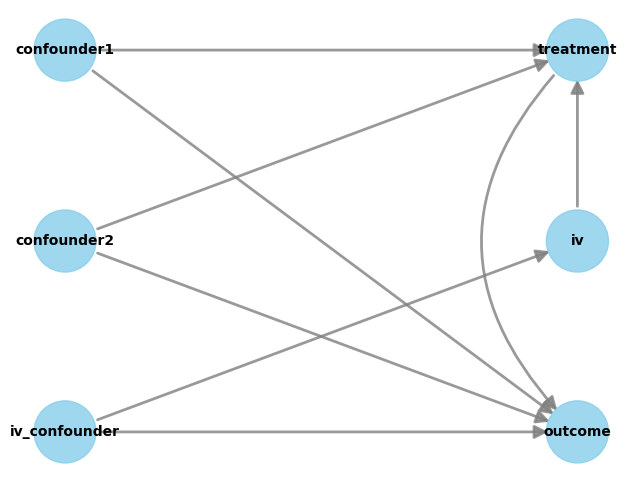

In [50]:
# create the DAG
nodes = ['iv','iv_confounder','treatment','confounder1','confounder2','outcome']
edges = [['iv','treatment'],
         ['treatment','outcome'],
         ['confounder1','treatment'],
         ['confounder1','outcome'],
         ['confounder2','treatment'],
         ['confounder2','outcome'],
         ['iv_confounder','iv'],
         ['iv_confounder','outcome']
        ]
gml_graph = 'graph [directed 1\n'

for node in nodes:
  gml_graph += f'\tnode [id "{node}" label "{node}"]\n'

for edge in edges:
  gml_graph += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'

gml_graph += ']'

model = CausalModel(
    data = df,
    treatment = 'treatment',
    outcome = 'outcome',
    graph = gml_graph
)
model.view_model()

In [52]:
# Start with a backdoor method that fully blocks all backdoor paths
X = df[['treatment','confounder1','confounder2','iv_confounder']].astype(float)
y = df[['outcome']].astype(float)

X = sm.add_constant(X)

ols = sm.OLS(y, X).fit()

print(ols.summary().tables[1])

                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0183      0.012      1.554      0.120      -0.005       0.041
treatment         5.0076      0.007    750.395      0.000       4.995       5.021
confounder1       0.1968      0.001    146.218      0.000       0.194       0.199
confounder2      -0.8015      0.001   -553.013      0.000      -0.804      -0.799
iv_confounder    -1.9999      0.002  -1301.442      0.000      -2.003      -1.997


When blocking all backdoor pathways we get an estimate that is really close to the effect of 5 that was assigned when the dataset was generated. But what if confounder 1 is unobserved? can we still use an IV method even if the IV is correlated with the outcome if we block the backdoor path when predicting the treatment?

In [55]:
# Stage 1
X = df[['iv','iv_confounder']].astype(float)
y = df['treatment'].astype(float)

X = sm.add_constant(X)
ols = sm.OLS(y, X).fit()
print(ols.summary().tables[1])
# generate predicted values but force all values of the confounder to zero before predicting and save predictions as a column in the dataframe
X['iv_confounder']=0
df['treatment_pred']=ols.predict(X)


# Stage 2
X = df[['treatment_pred']].astype(float)
y = df['outcome'].astype(float)

X = sm.add_constant(X)
ols = sm.OLS(y, X).fit()
print(ols.summary().tables[1])

                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0854      0.015      5.537      0.000       0.055       0.116
iv                0.0398      0.002     18.600      0.000       0.036       0.044
iv_confounder    -0.0081      0.007     -1.197      0.231      -0.021       0.005
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3130      0.091      3.434      0.001       0.134       0.492
treatment_pred   -10.3219      0.101   -101.868      0.000     -10.521     -10.123
